# Hybrid Training

So for the retraining campaign, I started looking into training w/ a hybrid sample from Franscesco, so this is just starting to look at some results!

Dec 2018

In [1]:
import numpy as np
import h5py
import sys
import pandas as pd
import xarray as xr

sys.path.append("..")
from usefulFcts import *
from trainNet import *
from plottingFcts import *

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

Using TensorFlow backend.


My first traaining was w/ only 3m jets, but next I'm going to try to train w/ 5m!

In [2]:
subDir = 'mc16d_PFlow_hybrid_1.5TeV'
dataDir = '../data/'+subDir
vStr = "sd0_sz0_nNextToInnHits_nInnHits_nsharedBLHits_nsplitBLHits_nsharedPixHits_nsplitPixHits_nsharedSCTHits_logNorm_ptfrac_dr_norm_nPixHits_nSCTHits"
dataTag = "3m_15trks_{}_sd0_rev".format(vStr)

f_name = "{}/data_{}_4trkClasses.hdf5".format(dataDir,dataTag)

f = h5py.File(f_name,"r")
    
X = f['X_test'][:]
y = f['y_test'][:]
ix = f['ix_test'][:]

f.close()

In [4]:
_, nTrks, nFeatures = X.shape

In [5]:
modelDir = '../models/'+subDir
m = myLSTM(modelDir=modelDir, nFeatures=nFeatures, dataTag=dataTag, loadModel=True)

Initialize method from myModel()
Loading previously trained LSTM


acc
loss
val_acc
val_loss


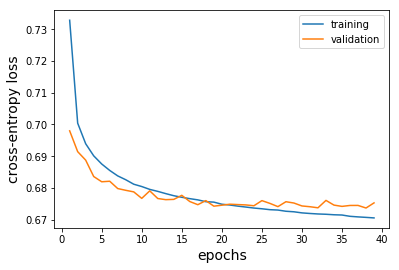

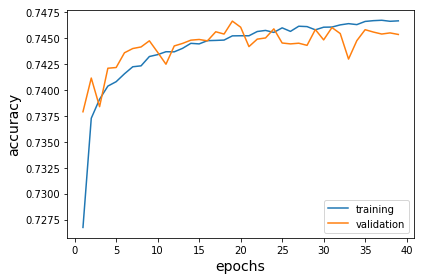

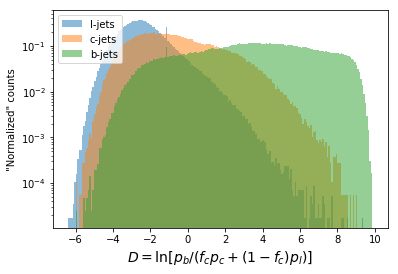

In [6]:
leffs, ceffs, beffs = [], [], []
trainingMetrics(m.modelName,modelDir=modelDir)

leff, ceff, beff = sigBkgEff(m, X, y, ix,subDir=subDir)

leffs.append(leff)
ceffs.append(ceff)
beffs.append(beff)

Ok, so it's not clear to me that the model has converged, I think I'm going to try training for longer!

../plottingFcts.py:431: RuntimeWarning: divide by zero encountered in true_divide
  plt.semilogy(teff, np.divide(1,beff), style, color=color, label=label)


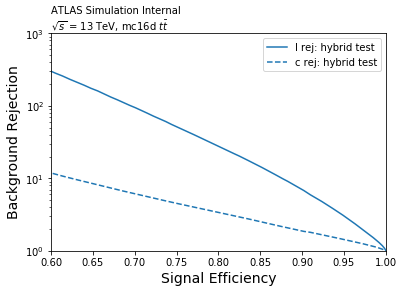

In [7]:
btagROC(beffs, leffs, ceffs, ['hybrid test'])

Ok, so the performance is pretty low, but maybe this is just due to the Z' that I also have in the test file?

- Plan: Test on jets with $p_T$ below 300 GeV

To do this, I'll need to extract the jet $p_T$ from the dataframe

In [8]:
dataTag = '3m_15trks_sd0_rev'

jet_df = pd.read_hdf('{}/jet_{}.h5'.format(dataDir,dataTag), key='jet_df')

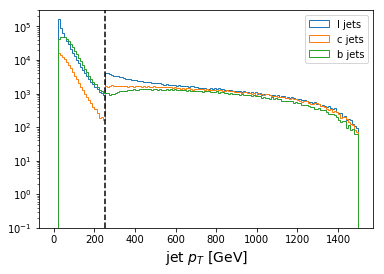

In [9]:
for yi,flav in enumerate(['l','c','b']):
    
    var  = jet_df.loc[ix,'pt']
    mask = (y==yi)
    
    plt.hist(var[mask],label='{} jets'.format(flav),
             bins=150,range=(0,1500),
             histtype='step',log=True)
    
plt.xlabel('jet $p_T$ [GeV]',fontsize=14)
plt.legend()
plt.savefig('../figures/mc16d_PFlow_hybrid_1.5TeV/jet_pT.pdf')

plt.plot([250,250],[.1,3e5],'k--')
plt.ylim(.1,3e5)
plt.show()

Ok, so if I look at jets with $p_T < 250$ GeV, I'll start probing the ttbar performance!

In [10]:
pT_mask = (jet_df.loc[ix,'pt'] < 250)

In [ ]:
leff, ceff, beff = sigBkgEff(m, X[pT_mask], y[pT_mask], ix[pT_mask],
                             subDir=subDir,tag='pT<250GeV')

leffs.append(leff)
ceffs.append(ceff)
beffs.append(beff)

In [ ]:
btagROC(beffs, leffs, ceffs, ['hybrid test','test $p_T^{jet}$ < 250 GeV'],
        title='hybrid training')

Recall: I had rejections of about 800 before with EMTopo. If this is an optimization issue, I could
1. Train w/ more jets
2. Look into some different reweighting schemes, such as the $p_T$ reweighting scheme that Manuel is using!

(I think he's just reweighting each bin to whichever option has the lowest stats.)